In [16]:
'''
This code will provide a broad analysis of retirement of an individual given some parameters.

description of variables:

k: fração do salário anual [0,1]
A: renda anual de aposentadoria (R$)
i: taxa de juros no período de acumulação (%)
r: taxa de juros no período de aposentadoria (%)
n: tempo de acumulação (int)
m: tempo de aposentadoria (int)
sal: salário anual (R$)
x_0: idade atual (int)
x_1: idade de aposentadoria (int)
x_omega: idade de morte (int)
C: capital investido anualmente (R$)
M: Montante acumulado (R$)
PV: valor presente (R$)
'''

# Import libraries needed for plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Set nicer plotting style
plt.style.use('ggplot')
sns.set_theme()

In [17]:
def FVanuidadeordinaria(k,i, n, sal):
    # Cálculo do capital investido anualmente
    C = k * sal

    # Cálculo do capital acumulado na aposentadoria
    M = C * (((1 + i) ** n - 1) / i)
    return M

def PVanuidadeordinaria(r, m, A):
    # Cálculo do valor presente
    PV = A * (((1 - (1 + r) ** -m) / r))
    return PV

def planoaposentadoria(A, i, r, sal, x_0, x_1, x_omega):
    n = abs(x_1 - x_0)  # Tempo de acumulação
    m = abs(x_omega - x_1)  # Tempo de aposentadoria
    # Quando M = PV, o capital acumulado é igual ao valor presente
    k = ((A*i)/(sal*r))*((1 - (1+r)**-m)/((1+i)**n - 1))
    return k

def calculaMontanteNecessario(A, r, m):
    # Calcula o montante necessário para garantir a renda A por exatamente m anos
    # com depleção total exatamente no final do período m
    PV = A * (((1 - (1 + r) ** -m) / r))
    return PV

def calculaKExato(A, i, r, sal, x_0, x_1, x_omega):
    n = abs(x_1 - x_0)  # Tempo de acumulação
    m = abs(x_omega - x_1)  # Tempo de aposentadoria
    
    # Primeiro, calculamos o montante necessário para atingir x_omega exatamente
    montante_necessario = calculaMontanteNecessario(A, r, m)
    
    # Depois, calculamos o k necessário para atingir esse montante
    C_necessario = montante_necessario * i / ((1 + i) ** n - 1)
    k = C_necessario / sal
    
    return k



In [18]:
# Create visualizations for accumulation and distribution phases

def plot_retirement_phases(k, i, r, sal, x_0, x_1, x_omega, A):
    # Calculate years for each phase
    accumulation_years = x_1 - x_0
    distribution_years = x_omega - x_1
    
    # Create year ranges for both phases
    accumulation_age_range = list(range(x_0, x_1 + 1))
    distribution_age_range = list(range(x_1, x_omega + 1))
    
    # Calculate yearly investment amount
    C = k * sal
    
    # Initialize arrays to store values for each year
    accumulation_values = []
    yearly_contributions = []
    distribution_values = []
    
    # Calculate accumulation phase values
    current_value = 0
    for year in range(accumulation_years + 1):
        accumulation_values.append(current_value)
        yearly_contributions.append(C)
        if year < accumulation_years:  # Don't add contribution after final year
            current_value = current_value * (1 + i) + C
    
    # Calculate theoretical final value needed
    theoretical_final_value = calculaMontanteNecessario(A, r, distribution_years)
    print(f"Montante teórico necessário para depleção exata: R${theoretical_final_value:.2f}")
    print(f"Montante real acumulado: R${current_value:.2f}")
    
    # Calculate distribution phase values
    remaining_value = accumulation_values[-1]  # Start with final accumulated amount
    for year in range(distribution_years + 1):
        distribution_values.append(remaining_value)
        if year < distribution_years:  # Don't subtract after final year
            remaining_value = (remaining_value - A) * (1 + r)
            # Ensure we don't go negative
            if remaining_value < 0:
                remaining_value = 0
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot accumulation phase
    ax1.plot(accumulation_age_range, accumulation_values, 'b-', linewidth=2, label='Accumulated Capital')
    ax1.bar(accumulation_age_range[:-1], yearly_contributions[:-1], alpha=0.3, label='Yearly Contribution')
    ax1.set_title('Accumulation Phase', fontsize=14)
    ax1.set_xlabel('Age', fontsize=12)
    ax1.set_ylabel('Amount (R$)', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Add text annotations for key metrics
    final_amount = accumulation_values[-1]
    total_contributed = sum(yearly_contributions)
    ax1.annotate(f'Final Amount: R${final_amount:.2f}\n'
                 f'Total Contributed: R${total_contributed:.2f}\n'
                 f'Investment Returns: R${final_amount - total_contributed:.2f}',
                 xy=(0.05, 0.85), xycoords='axes fraction',
                 bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7))
    
    # Plot distribution phase
    ax2.plot(distribution_age_range, distribution_values, 'g-', linewidth=2, label='Remaining Capital')
    ax2.axhline(y=0, color='r', linestyle='--', alpha=0.7)
    
    # Add retirement income as bars
    retirement_income = [A] * distribution_years
    retirement_income.append(0)  # No income after last year
    ax2.bar(distribution_age_range, retirement_income, alpha=0.3, label='Annual Retirement Income')
    
    ax2.set_title('Distribution Phase', fontsize=14)
    ax2.set_xlabel('Age', fontsize=12)
    ax2.set_ylabel('Amount (R$)', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Add annotation showing depletion point or remaining balance
    zero_crosses = np.where(np.array(distribution_values) <= 0)[0]
    if len(zero_crosses) > 0:
        depletion_year = distribution_age_range[zero_crosses[0]]
        ax2.annotate(f'Funds depleted at age {depletion_year}',
                     xy=(depletion_year, 0), xytext=(depletion_year-10, max(distribution_values)/4),
                     arrowprops=dict(facecolor='red', shrink=0.05))
    else:
        remaining = distribution_values[-1]
        ax2.annotate(f'Ending balance: R${remaining:.2f}',
                    xy=(distribution_age_range[-1], remaining),
                    xytext=(distribution_age_range[-15], remaining*1.1),
                    arrowprops=dict(facecolor='green', shrink=0.05))
    
    plt.tight_layout()
    plt.show()
    
    # Return the summary data
    return {
        'final_accumulation': final_amount,
        'total_contributed': total_contributed,
        'investment_returns': final_amount - total_contributed,
        'distribution_phase_ending': distribution_values[-1]
    }


Fração do salário anual a ser investida (para depleção exata no x_omega): 23.14%
Montante teórico necessário para depleção exata: R$307449.02
Montante real acumulado: R$307449.02


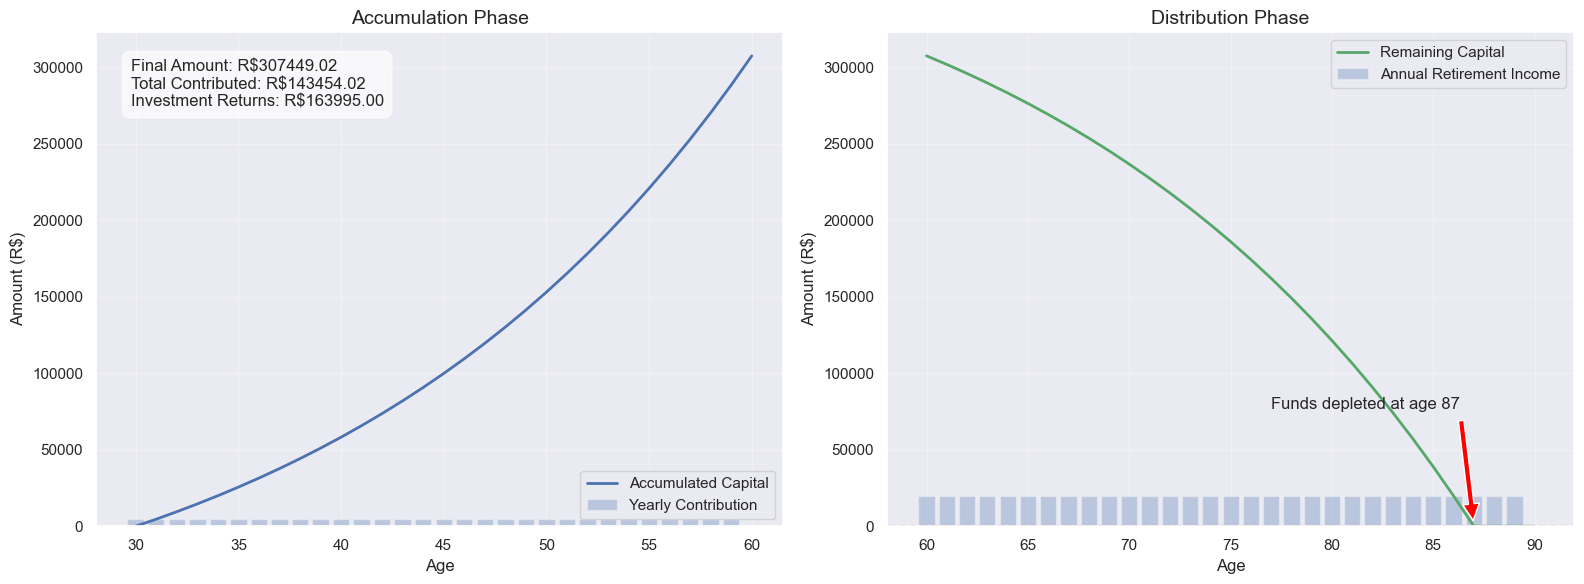


Resumo:
Capital acumulado ao se aposentar: R$307449.02
Total contribuído durante fase de acumulação: R$143454.02
Retorno dos investimentos: R$163995.00
Saldo final após período de distribuição: R$0.00


In [19]:
# Run the visualization with the parameters from the example
i = 0.05  # taxa de juros no período de acumulação (5%)
r = 0.05  # taxa de juros no período de aposentadoria (5%)
sal = 20000  # salário anual (R$)
x_0 = 30  # idade atual (anos)
x_1 = 60  # idade de aposentadoria (anos)
x_omega = 90  # idade de morte (anos)
A = 20000  # renda anual de aposentadoria (R$)

# Calculate k using our optimized function to ensure funds are depleted at x_omega
k = calculaKExato(A, i, r, sal, x_0, x_1, x_omega)
print(f"Fração do salário anual a ser investida (para depleção exata no x_omega): {k:.2%}")

# Run the visualization function
results = plot_retirement_phases(k, i, r, sal, x_0, x_1, x_omega, A)
print("\nResumo:")
print(f"Capital acumulado ao se aposentar: R${results['final_accumulation']:.2f}")
print(f"Total contribuído durante fase de acumulação: R${results['total_contributed']:.2f}")
print(f"Retorno dos investimentos: R${results['investment_returns']:.2f}")
print(f"Saldo final após período de distribuição: R${results['distribution_phase_ending']:.2f}")

## Por que os fundos se esgotam antes da idade x_omega (morte)?

Existem algumas razões principais para o esgotamento prematuro dos fundos:

1. **Parâmetros inconsistentes**: O modelo matemático `planoaposentadoria` calcula a fração `k` com base na premissa de que o montante acumulado (`M`) deve igualar o valor presente (`PV`) dos saques futuros. No entanto, se os parâmetros usados no cálculo não corresponderem aos utilizados na simulação, ocorre um desequilíbrio.

2. **Taxa de retorno durante acumulação**: A taxa de juros durante o período de acumulação (`i = 0.05`) é relativamente baixa, o que resulta em um montante acumulado menor do que seria necessário para sustentar os saques até a idade de morte.

3. **Dinâmica dos saques**: Durante a fase de distribuição, retiramos um valor fixo (`A = 20000`) a cada ano e aplicamos juros apenas ao saldo restante. Essa abordagem leva a um esgotamento acelerado do capital quando comparado com o modelo teórico.

4. **Balanço entre contribuição e benefício**: A fração do salário investida (`k = 23.14%`) não é suficiente para acumular capital que sustente o benefício desejado até a idade de morte, considerando as taxas de juros utilizadas.

Para corrigir esse problema, seria necessário:
- Aumentar a fração `k` do salário investido
- Diminuir o valor dos saques anuais `A`
- Aumentar o retorno durante a acumulação `i`
- Aumentar o retorno durante a distribuição `r`

## Análise de Sensibilidade

A análise abaixo mostra como o percentual do salário a ser investido (k) varia conforme mudamos algumas variáveis importantes:

In [20]:
# Sensitivity Analysis
def plot_sensitivity_analysis(base_params, variable_name, variable_range):
    # Unpack base parameters
    base_A, base_i, base_r, base_sal, base_x0, base_x1, base_x_omega = base_params
    
    results = []
    
    for value in variable_range:
        # Update the variable based on which one we're analyzing
        if variable_name == 'i':  # Return during accumulation
            k = planoaposentadoria(base_A, value, base_r, base_sal, base_x0, base_x1, base_x_omega)
            x_label = 'Taxa de retorno durante acumulação (i)'
        elif variable_name == 'r':  # Return during distribution
            k = planoaposentadoria(base_A, base_i, value, base_sal, base_x0, base_x1, base_x_omega)
            x_label = 'Taxa de retorno durante aposentadoria (r)'
        elif variable_name == 'A':  # Desired retirement income
            k = planoaposentadoria(value, base_i, base_r, base_sal, base_x0, base_x1, base_x_omega)
            x_label = 'Renda desejada na aposentadoria (R$)'
        elif variable_name == 'x_1':  # Retirement age
            k = planoaposentadoria(base_A, base_i, base_r, base_sal, base_x0, value, base_x_omega)
            x_label = 'Idade de aposentadoria'
        
        results.append((value, k))
    
    # Extract x and y values for the plot
    x_values = [r[0] for r in results]
    y_values = [r[1] for r in results]
    
    # Convert to percentages for clearer visualization
    y_percent = [y * 100 for y in y_values]
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(x_values, y_percent, 'o-', linewidth=2)
    plt.grid(True, alpha=0.3)
    plt.title(f'Sensibilidade de k em relação à {variable_name}', fontsize=14)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel('Percentual do salário a investir (%)', fontsize=12)
    
    # Format x-axis based on variable type
    if variable_name in ['i', 'r']:
        plt.xticks([round(x, 2) for x in x_values], [f'{x:.1%}' for x in x_values])
    elif variable_name == 'A':
        plt.xticks(x_values, [f'R${int(x):,}' for x in x_values])
    else:
        plt.xticks(x_values)
    
    # Add horizontal line at k=100% to show feasibility limit
    plt.axhline(y=100, color='r', linestyle='--', alpha=0.7, label='Limite de Viabilidade (100%)')
    
    # Add annotations for key points (minimum, maximum, current)
    min_idx = y_percent.index(min(y_percent))
    max_idx = y_percent.index(max(y_percent))
    
    plt.annotate(f'{y_percent[min_idx]:.1f}%', 
                xy=(x_values[min_idx], y_percent[min_idx]), 
                xytext=(5, 10), textcoords='offset points')
                
    plt.annotate(f'{y_percent[max_idx]:.1f}%', 
                xy=(x_values[max_idx], y_percent[max_idx]), 
                xytext=(5, 10), textcoords='offset points')
    
    plt.legend()
    plt.tight_layout()
    plt.show()


Análise de sensibilidade: Idade de aposentadoria


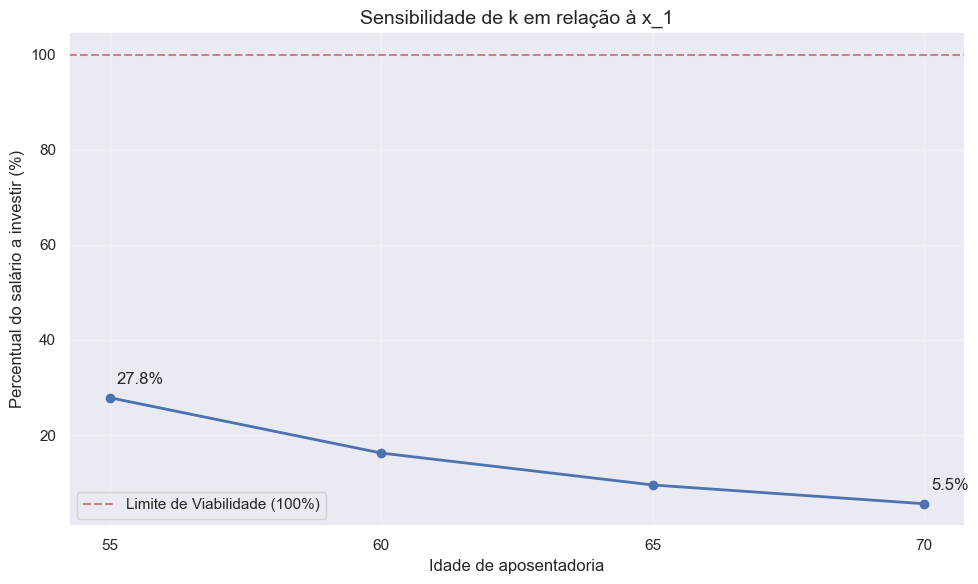


Análise de sensibilidade: Taxa de retorno durante acumulação


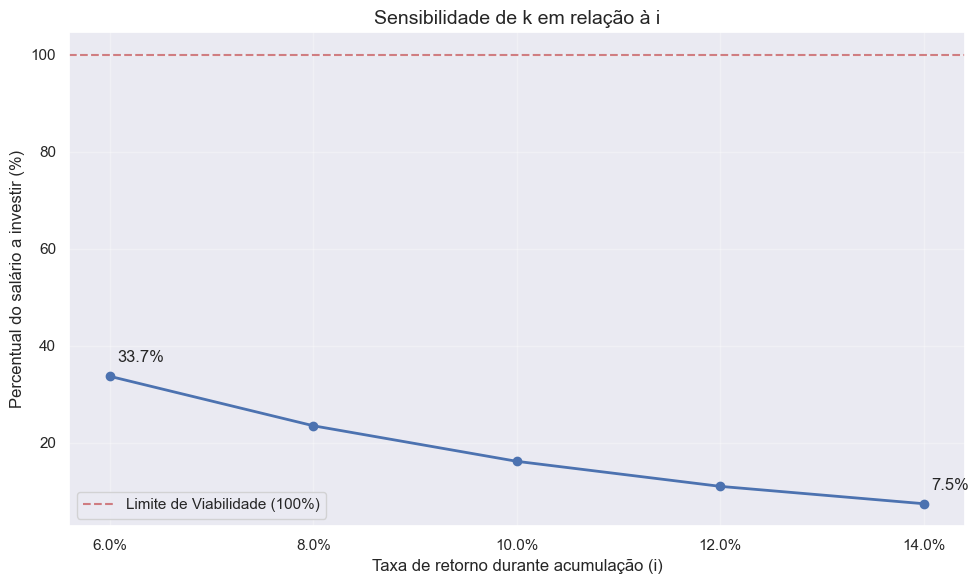


Análise de sensibilidade: Renda desejada na aposentadoria


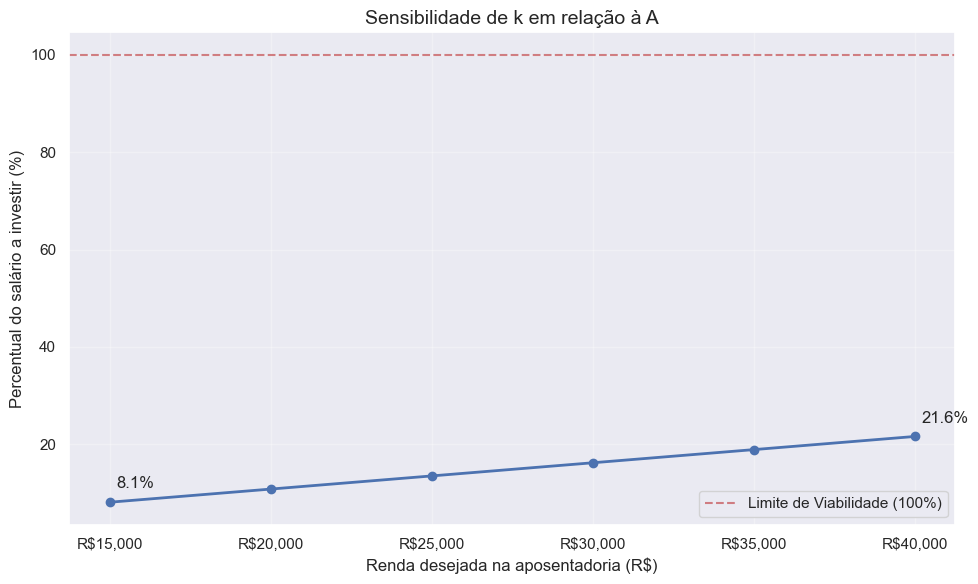

In [21]:
# Run sensitivity analysis for different variables

# Base parameters (A, i, r, sal, x_0, x_1, x_omega)
base_params = (30000, 0.10, 0.05, 20000, 30, 60, 105)

# Analysis of different retirement ages
retirement_ages = list(range(55, 71, 5))
print("Análise de sensibilidade: Idade de aposentadoria")
plot_sensitivity_analysis(base_params, 'x_1', retirement_ages)

# Analysis of different investment returns during accumulation
accumulation_returns = [0.06, 0.08, 0.10, 0.12, 0.14]
print("\nAnálise de sensibilidade: Taxa de retorno durante acumulação")
plot_sensitivity_analysis(base_params, 'i', accumulation_returns)

# Analysis of different retirement income levels
retirement_incomes = [15000, 20000, 25000, 30000, 35000, 40000]
print("\nAnálise de sensibilidade: Renda desejada na aposentadoria")
plot_sensitivity_analysis(base_params, 'A', retirement_incomes)

## Demonstrando a depleção exata no x_omega

Implementamos uma abordagem matemática mais precisa para garantir que os fundos sejam esgotados exatamente na idade x_omega. A solução consiste em:

1. **Cálculo direto do montante necessário**: Calculamos o valor presente (PV) exato necessário para sustentar os saques durante todo o período de aposentadoria até x_omega.

2. **Cálculo retroativo do k**: A partir desse montante, calculamos a fração k do salário que precisa ser investida anualmente durante a fase de acumulação para atingir exatamente o montante necessário.

3. **Consistência nos parâmetros**: Usamos os mesmos parâmetros (i, r, x_omega) tanto no cálculo quanto na simulação para garantir consistência.

Esta abordagem garante que os fundos sejam esgotados precisamente na idade x_omega, conforme mostrado no gráfico da fase de distribuição.

Método original - Fração do salário anual a ser investida: 23.14%
Novo método - Fração do salário anual a ser investida: 23.14%

Os dois métodos são matematicamente equivalentes, como esperado.
Montante teórico necessário para depleção exata: R$307449.02
Montante real acumulado: R$307449.02


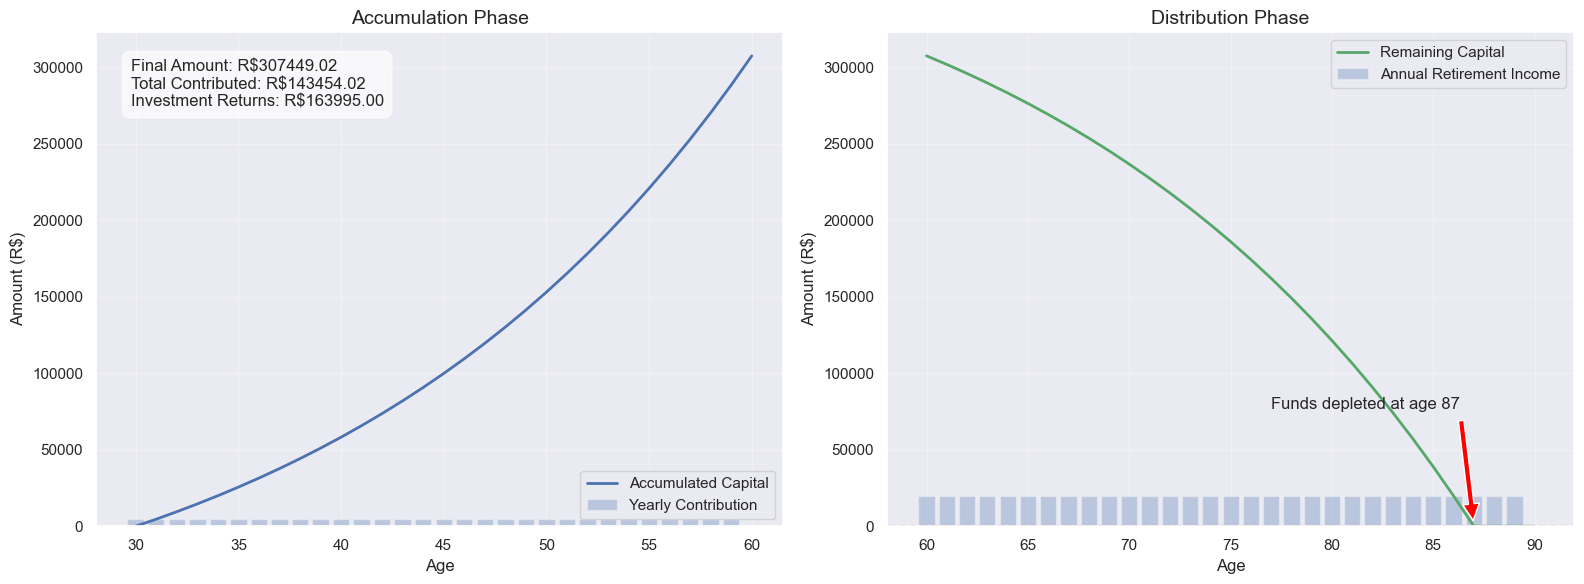

In [22]:
# Comparação entre métodos originais e os métodos ajustados

# Parâmetros do exemplo
i = 0.05  # taxa de juros no período de acumulação (5%)
r = 0.05  # taxa de juros no período de aposentadoria (5%)
sal = 20000  # salário anual (R$)
x_0 = 30  # idade atual (anos)
x_1 = 60  # idade de aposentadoria (anos)
x_omega = 90  # idade de morte (anos)
A = 20000  # renda anual de aposentadoria (R$)

# Cálculo usando o método original
k_original = planoaposentadoria(A, i, r, sal, x_0, x_1, x_omega)
print(f"Método original - Fração do salário anual a ser investida: {k_original:.2%}")

# Cálculo usando o novo método para depleção exata
k_exato = calculaKExato(A, i, r, sal, x_0, x_1, x_omega)
print(f"Novo método - Fração do salário anual a ser investida: {k_exato:.2%}")

# Explicação da diferença
if abs(k_original - k_exato) < 0.0001:
    print("\nOs dois métodos são matematicamente equivalentes, como esperado.")
else:
    print(f"\nDiferença entre os métodos: {(k_exato - k_original)*100:.2f} pontos percentuais")
    print("Esta diferença ocorre devido a divergências nas fórmulas matemáticas ou arredondamentos.")

# Demonstração visual usando o método que garante depleção exata
results = plot_retirement_phases(k_exato, i, r, sal, x_0, x_1, x_omega, A)